# This notebook explores the variance in the imbalance of the Netherlands

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import seaborn as sns
import pandas as pd
from datetime import datetime
import matplotlib.ticker as ticker

sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

KeyboardInterrupt: 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load data
dl = covid19_soccer.dataloader.Dataloader_gender(countries=["NL"])

In [4]:
cases = dl._cases.xs(key="total",level="age_group") # there is only one age group
cases = cases.loc[datetime(2021,1,1):datetime(2022,1,1),:]

WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


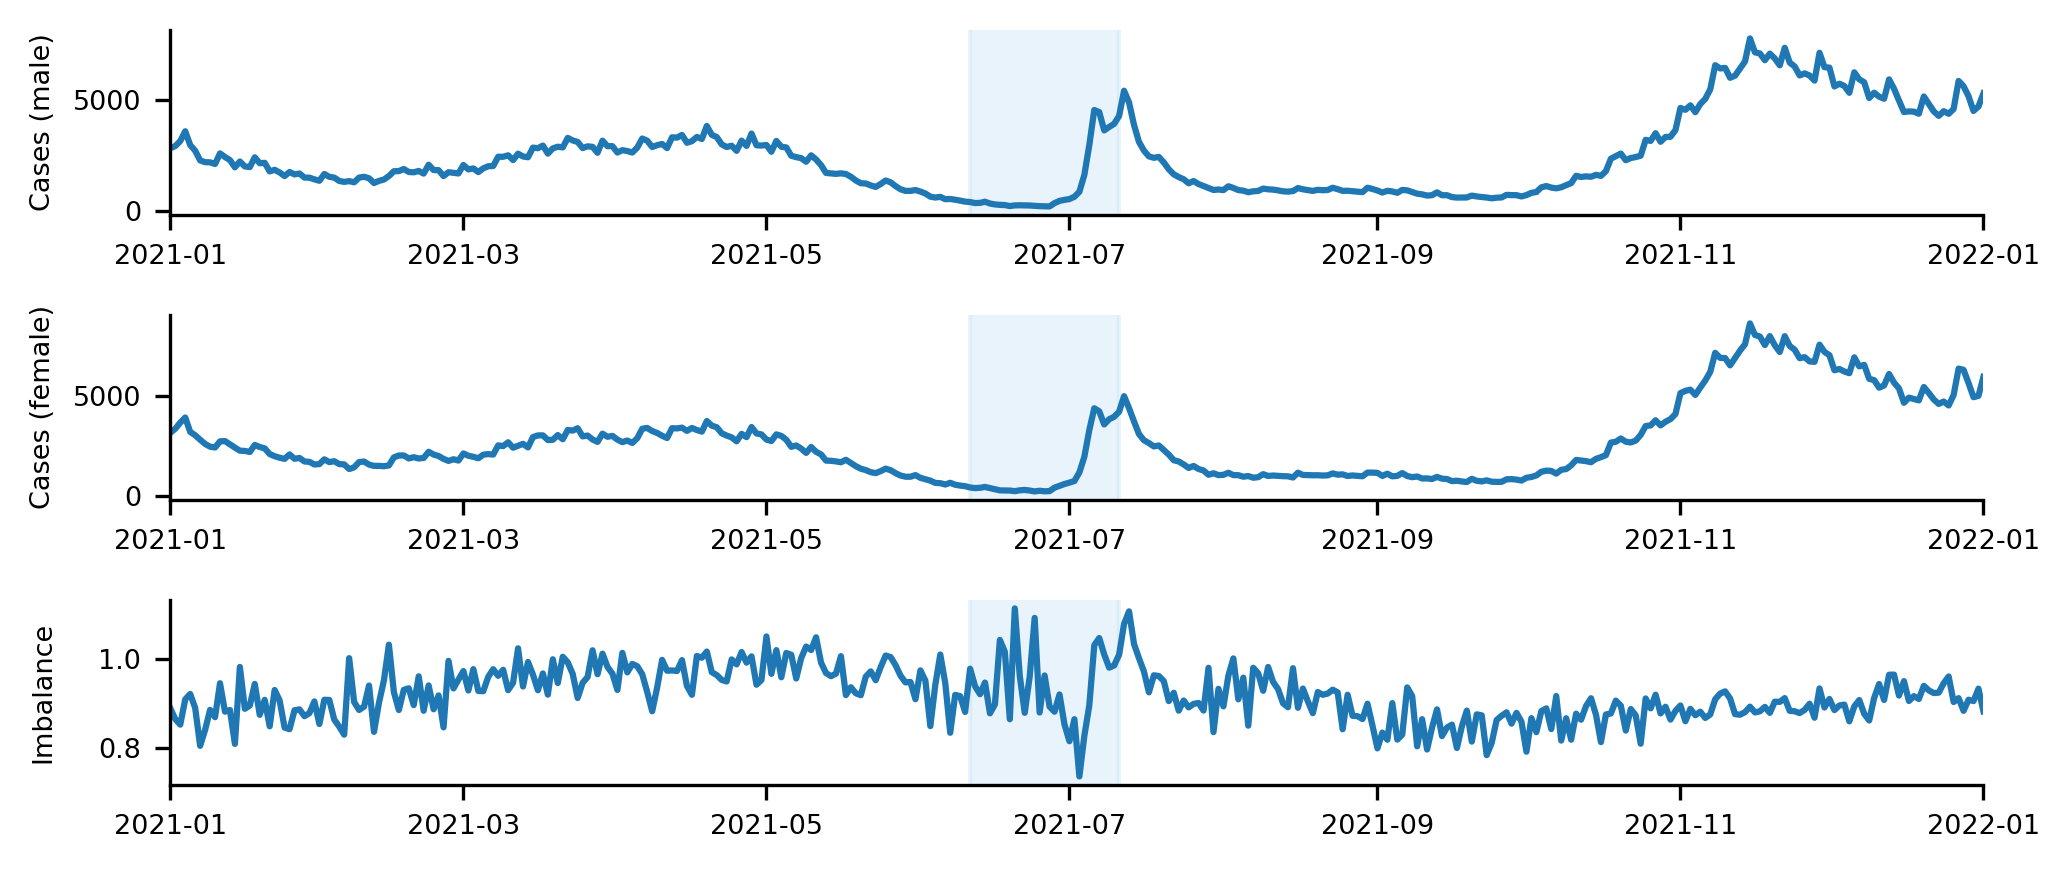

In [5]:
from covid19_soccer.plot.timeseries import _uefa_range, _format_date_xticks

# Plot gender by date
fig, axes = plt.subplots(3,1,figsize=(7,3))

male_cases = cases.xs(key="male",level="gender")
female_cases = cases.xs(key="female",level="gender")
imbalance = male_cases/female_cases

axes[0].plot(male_cases)
axes[0].set_ylabel("Cases (male)")

axes[1].plot(female_cases)
axes[1].set_ylabel("Cases (female)")

axes[2].plot(imbalance)
axes[2].set_ylabel("Imbalance")

for ax in axes:
    ax.set_xlim(datetime(2021,1,1),datetime(2022,1,1))
    #_format_date_xticks(ax)
    _uefa_range(ax)
    
fig.tight_layout()
fig.align_ylabels(axes)
    
plt.show()

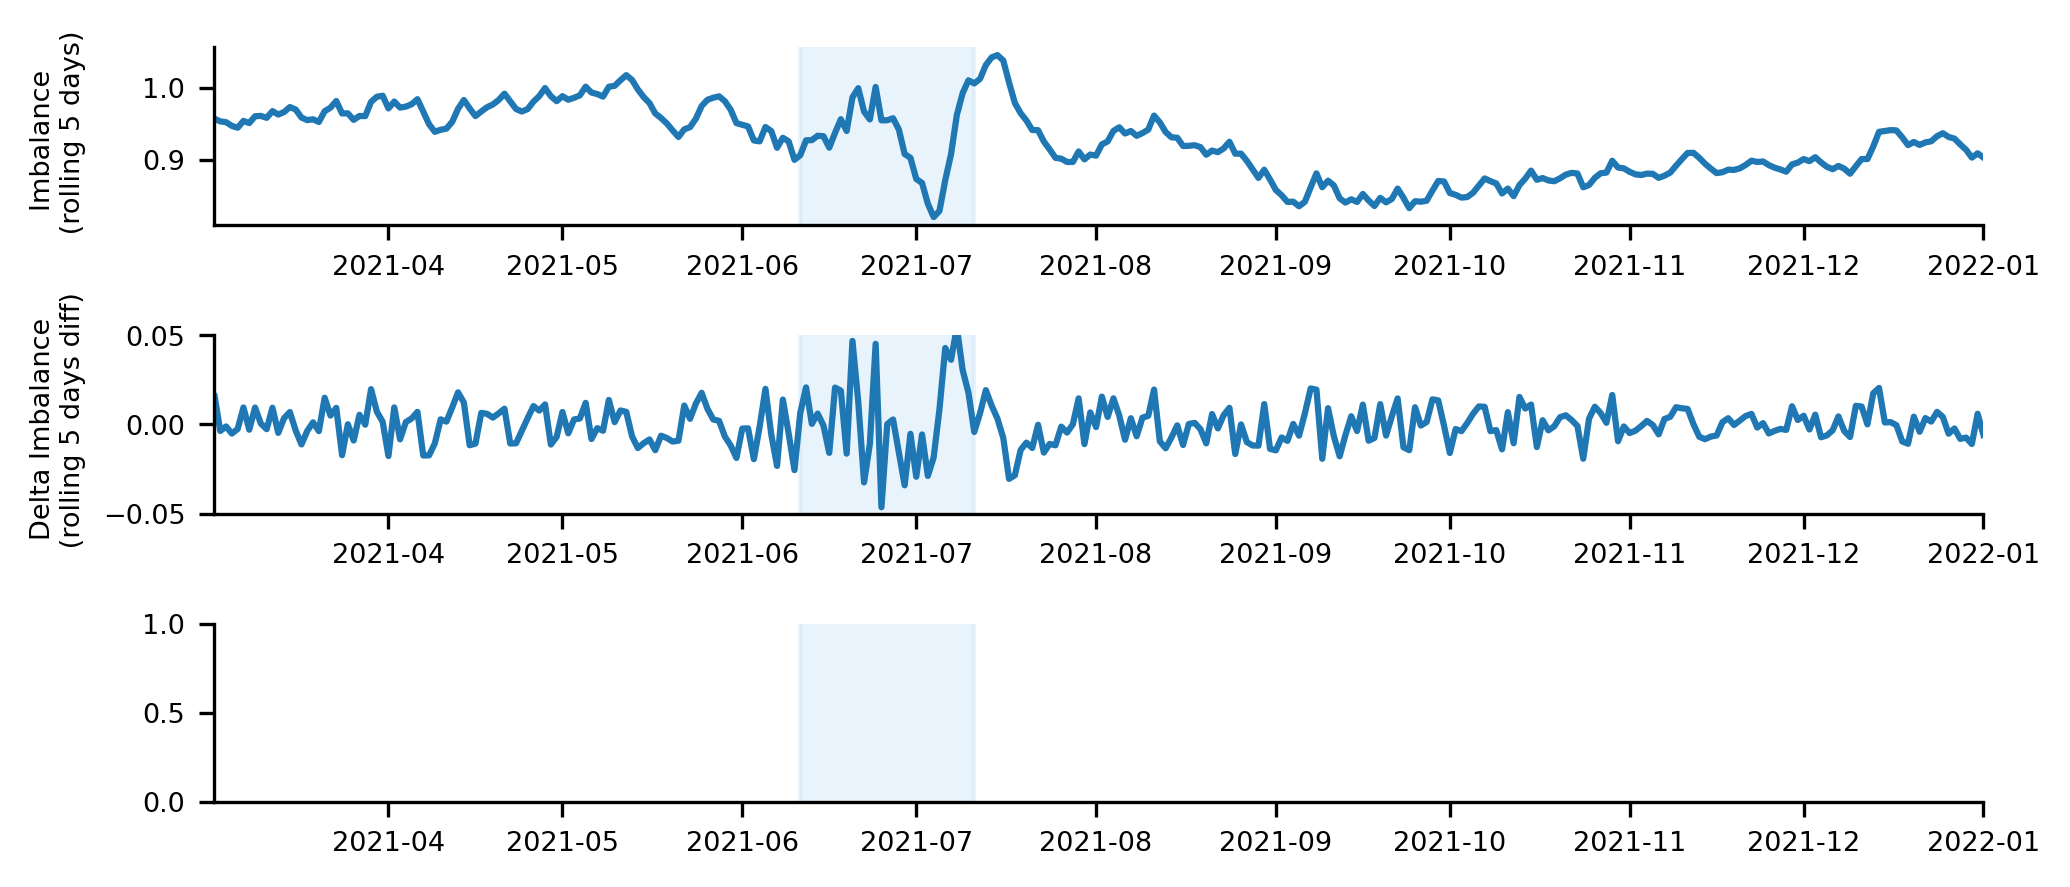

In [6]:
# Rolling average

fig, axes = plt.subplots(3,1,figsize=(7,3))

rolling_avg_imbalance = imbalance.rolling(5).mean()

axes[0].plot(rolling_avg_imbalance)
axes[0].set_ylabel("Imbalance \n (rolling 5 days)")



axes[1].plot(rolling_avg_imbalance.diff(1))
axes[1].set_ylabel("Delta Imbalance \n (rolling 5 days diff)")
axes[1].set_ylim(-0.05,0.05)

for ax in axes:
    ax.set_xlim(datetime(2021,3,2),datetime(2022,1,1))
    #_format_date_xticks(ax)
    _uefa_range(ax)

fig.tight_layout()
fig.align_ylabels(axes)
    
plt.show()

In [7]:
# Calc variance before/after and during championship
bg_c = datetime(2021, 6, 11)
end_c = datetime(2021, 7, 11)


mask = np.any([imbalance.index < datetime(2021, 6, 11), imbalance.index > datetime(2021, 7, 11)],axis=0)

print("Non-soccer",np.var(imbalance[mask]))
print("Soccer",np.var(imbalance[bg_c:end_c]))
print("Total",np.var(imbalance))

Non-soccer NL    0.003061
dtype: float64
Soccer NL    0.006879
dtype: float64
Total NL    0.003418
dtype: float64


In [8]:
import pymc3 as pm
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma1 = pm.Normal("sigma_1", mu=np.var(imbalance)[0], sigma=1.0)
    sigma2 = pm.Normal("sigma_2", mu=np.var(imbalance)[0], sigma=1.0)
    
    # Prior for mu
    mu = pm.Uniform("mu",0,2)
    
    nu = pm.Exponential("nu_minus_one", 1 / 29.0) + 1
    
    soccer = pm.StudentT(
        "soccer",
        nu=nu,
        mu=mu,
        sigma=sigma1,
        observed=imbalance[bg_c:end_c]
    )
    nonSoccer = pm.StudentT(
        "no-soccer",
        nu=nu,
        mu=mu,
        sigma=sigma2,
        observed=imbalance[mask]
    )
    
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, mu, sigma_2, sigma_1]
INFO     [pymc3] NUTS: [nu_minus_one, mu, sigma_2, sigma_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 9 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 9 seconds.


In [9]:
print(np.percentile(trace.posterior["sigma_1"],(2.5,50,97.5)))
print(np.percentile(trace.posterior["sigma_2"],(2.5,50,97.5)))


[0.06728979 0.08574373 0.11365851]
[0.04985833 0.05421558 0.05891   ]


<ipython-input-21-52d3e1da845e>:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color="red", lw=0,),)
<ipython-input-21-52d3e1da845e>:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color="orange", lw=0,),)


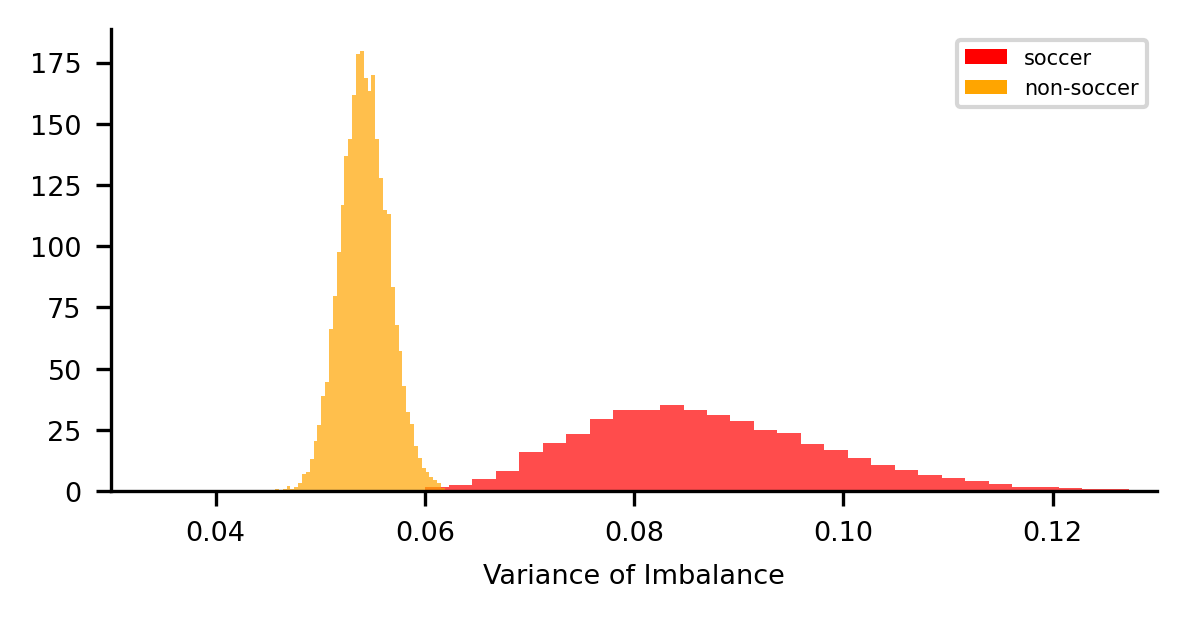

In [21]:
from matplotlib.patches import Patch
from covid19_soccer.plot.distributions import _plot_posterior

fig, ax= plt.subplots(1,1,figsize=(4.5,2))
ax.set_xlim(0.03,0.13)
_plot_posterior(trace.posterior["sigma_1"].to_numpy().flatten(),ax=ax,color="red")
_plot_posterior(trace.posterior["sigma_2"].to_numpy().flatten(),ax=ax,color="orange")

lines = []
labels = []
lines.append(Patch([0], [0], color="red", lw=0,),)
labels.append("soccer")
lines.append(Patch([0], [0], color="orange", lw=0,),)
labels.append("non-soccer")

ax.legend(lines,labels)
ax.set_xlabel("Variance of Imbalance")
plt.show()